<a href="https://colab.research.google.com/github/SoumadipDey/Intel-oneAPI-Hackathon/blob/main/Intel_ML_Hackathon_22_03_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Polynomial Regression on Fish Market Dataset to cluster species of fish.**

Using the intel optimized sklearn 

**Installing the Intel oneAPI optmized version of sklearn**

In [81]:
!pip install scikit-learn-intelex --quiet

**Importing required packages**

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearnex import patch_sklearn
sns.set_theme()
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


**Loading the Dataset**

In [83]:
fish_df = pd.read_csv("https://raw.githubusercontent.com/SoumadipDey/datasets/main/Fish.csv")
print("Shape of Dataframe: ",fish_df.shape)
fish_df.head()

Shape of Dataframe:  (159, 7)


,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


**Cleaning NaN values if any**



In [84]:
fish_df.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

**Finding and plotting correlation among the variables**

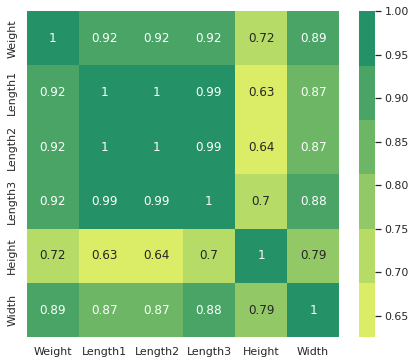

In [85]:
plt.figure(1,(7,6))
sns.heatmap(fish_df.drop(['Species'], axis = 1).corr(),
            annot = True, cmap = sns.color_palette('summer_r'),
)
plt.show()

From the above heatmap, it is clear that the features `Length1`, `Length2`, `Length3` have a very high degree of multicollinearity and thus need to be removed as to not skew the results or overfit the model.

In [86]:
try:
  fish_df.drop(['Length1','Length2','Length3'], axis = 1, inplace = True)
except KeyError:
  print("Length Columns already dropped!")
finally:
  print("Columns:", fish_df.columns.values)

Columns: ['Species' 'Weight' 'Height' 'Width']


**Outlier Detection for various species of Fishes**

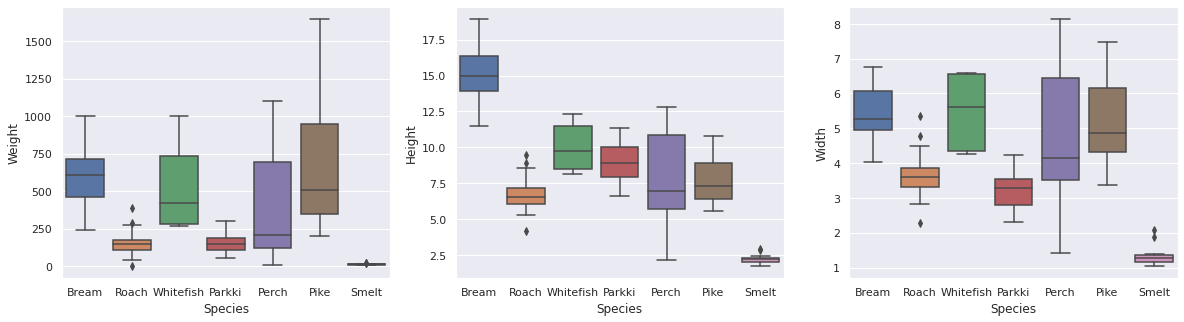

In [87]:
fig , ax = plt.subplots(1,3,figsize = (20,5))
sns.boxplot(data = fish_df, x = 'Species', y = 'Weight', ax = ax[0])
sns.boxplot(data = fish_df, x = 'Species', y = 'Height', ax = ax[1])
sns.boxplot(data = fish_df, x = 'Species', y = 'Width', ax = ax[2])
fig.show()

As we can see from the boxplots, there exist some outliers:


* There are *Weight*, *Height* and *Width* outliers for the Species `Roach`.   
* There are *Weight*, *Height* and *Width* outliers for the Species `Smelt`.



**Finding and removing the outliers**

In [88]:
def findOutliers(dataframe: pd.DataFrame) -> pd.DataFrame:
  Q1 = dataframe.quantile(0.25)
  Q3 = dataframe.quantile(0.75)
  IQR = Q3 - Q1
  upper_end = Q3 + 1.5 * IQR
  lower_end = Q1 - 1.5 * IQR 
  outlier = dataframe[(dataframe > upper_end) | (dataframe < lower_end)]
  return outlier

In [89]:
roach = fish_df.where(fish_df['Species'] == 'Roach').dropna()
smelt = fish_df.where(fish_df['Species'] == 'Smelt').dropna()

In [90]:
outliers = set()
for category in [roach, smelt]:
  for column in category.columns[1:]: 
      outliers.update(findOutliers(category[column]).index.values)

In [91]:
fish_df.drop(list(outliers), inplace = True)

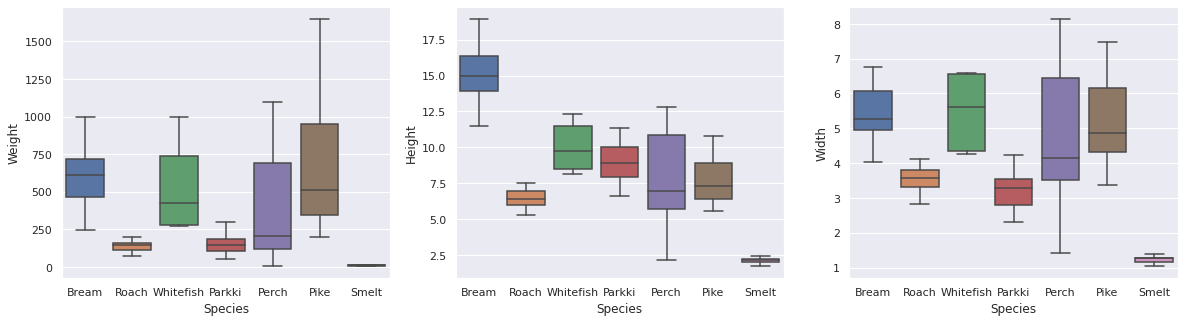

In [92]:
fig , ax = plt.subplots(1,3,figsize = (20,5))
sns.boxplot(data = fish_df, x = 'Species', y = 'Weight', ax = ax[0])
sns.boxplot(data = fish_df, x = 'Species', y = 'Height', ax = ax[1])
sns.boxplot(data = fish_df, x = 'Species', y = 'Width', ax = ax[2])
fig.show()

**Plotting relationships among the numeric variables**

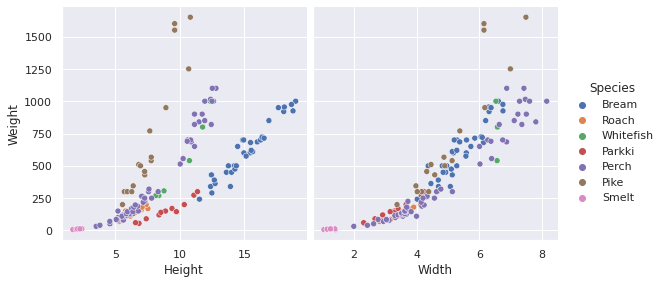

In [93]:
sns.pairplot(data = fish_df, 
             x_vars = fish_df.drop(['Weight','Species'],axis = 1).columns , 
             y_vars = 'Weight', hue = 'Species', height = 4, aspect = 1)
plt.show()

As it can be seen from the pairplot, the independent variables `Width`, `Height` seem to have a polynomial relationship with the dependent variable `Weight`. 

**Scaling The Numerical Values**

In [94]:
from sklearn.preprocessing import StandardScaler

ScalerWeight = StandardScaler().fit(fish_df['Weight'].values.reshape(-1,1))
ScalerHeight = StandardScaler().fit(fish_df['Height'].values.reshape(-1,1))
ScalerWidth = StandardScaler().fit(fish_df['Width'].values.reshape(-1,1))

fish_df['Weight'] = ScalerWeight.transform(fish_df['Weight'].values.reshape(-1,1))
fish_df['Height'] = ScalerWeight.transform(fish_df['Height'].values.reshape(-1,1))
fish_df['Width'] = ScalerWeight.transform(fish_df['Width'].values.reshape(-1,1))
fish_df.head()

,Species,Weight,Height,Width
0,Bream,-0.467215,-1.108634,-1.129506
1,Bream,-0.333632,-1.105962,-1.128711
2,Bream,-0.194484,-1.106246,-1.127624
3,Bream,-0.130476,-1.105266,-1.128294
4,Bream,0.055983,-1.106062,-1.126406


**OneHot Encoding the Species**

In [95]:
fish_df = fish_df.join(pd.get_dummies(fish_df.Species, prefix='Species_', drop_first = True))
fish_df.drop(['Species'], axis = 1, inplace = True)
fish_df.head()

,Weight,Height,Width,Species__Parkki,Species__Perch,Species__Pike,Species__Roach,Species__Smelt,Species__Whitefish
0,-0.467215,-1.108634,-1.129506,0,0,0,0,0,0
1,-0.333632,-1.105962,-1.128711,0,0,0,0,0,0
2,-0.194484,-1.106246,-1.127624,0,0,0,0,0,0
3,-0.130476,-1.105266,-1.128294,0,0,0,0,0,0
4,0.055983,-1.106062,-1.126406,0,0,0,0,0,0


**Seperating the variables**

In [96]:
X = fish_df.drop(['Weight'], axis = 1).values
y = fish_df['Weight'].values.reshape(-1,1)

In [97]:
print(X.shape,y.shape)

(152, 8) (152, 1)


**Creating Polynomial Features**

In [98]:
X = PolynomialFeatures(degree = 2).fit_transform(X)
X.shape

(152, 45)

**Splitting the dataset into training and validation sets**

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 11)

In [100]:
print("Training set dimensions: ",X_train.shape,y_train.shape)
print("Test set dimensions: ",X_test.shape,y_test.shape)

Training set dimensions:  (106, 45) (106, 1)
Test set dimensions:  (46, 45) (46, 1)


**Creating the model**

In [101]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

**Evaluating the model**

In [102]:
model.score(X_test,y_test)

0.9781655937949673

In [103]:
model.score(X_train,y_train)

0.9561589637166528

In [104]:
y_predicted = model.predict(X_test)
test_comparison_df = pd.DataFrame({"Actual Weight": ScalerWeight.inverse_transform(y_test).squeeze(),
                              "Predicted Weight":ScalerWeight.inverse_transform(y_predicted).squeeze()})
test_comparison_df['Residuals'] = test_comparison_df['Actual Weight'] - test_comparison_df['Predicted Weight']
test_comparison_df.head()

,Actual Weight,Predicted Weight,Residuals
0,900.0,890.709549,9.290451
1,40.0,24.615623,15.384377
2,950.0,1069.873611,-119.873611
3,55.0,72.704495,-17.704495
4,510.0,450.080075,59.919925


In [105]:
print("MSE Train:",mean_squared_error(y_train,model.predict(X_train)))
print("MSE Test:",mean_squared_error(y_test,y_predicted))
print("MAPE Train:",mean_absolute_percentage_error(y_train,model.predict(X_train))*100,"%")
print("MAPE Test:",mean_absolute_percentage_error(y_test,y_predicted)*100,"%")

MSE Train: 0.0431658541101049
MSE Test: 0.02248207487347282
MAPE Train: 23.84321681695139 %
MAPE Test: 17.970624339873787 %


**Histogram of Residuals**

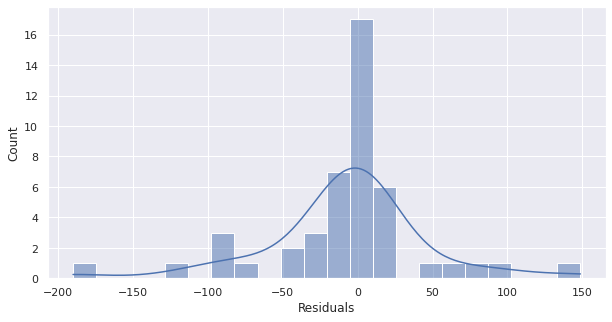

In [106]:
plt.figure(1,(10,5))
sns.histplot(data = test_comparison_df, x = 'Residuals', kde = True)
plt.show()

**Plotting the Predicted Weights against the Actual Weights**

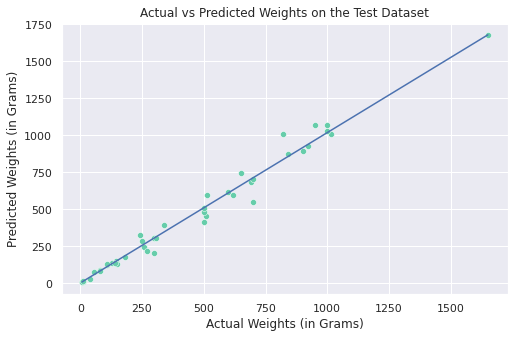

In [107]:
plt.figure(2,(8,5))
plt.xlabel("Actual Weights (in Grams)")
plt.ylabel("Predicted Weights (in Grams)")
plt.title("Actual vs Predicted Weights on the Test Dataset")
sns.scatterplot(data = test_comparison_df, x = 'Actual Weight', y = 'Predicted Weight', color = 'mediumaquamarine')
sns.lineplot(
    x = np.linspace(min(test_comparison_df['Actual Weight']), 
                    max(test_comparison_df['Actual Weight']),
                    num = len(test_comparison_df['Actual Weight'])), 
    y = np.linspace(min(test_comparison_df['Predicted Weight']),
                    max(test_comparison_df['Predicted Weight']),
                    num = len(test_comparison_df['Predicted Weight']))
)
plt.show()